Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$\sum_c f_c(\mu) \cdot \nu_c(\mu) \cdot \frac{p_c\left(x\right)}{p_\text{c}(x)} = \mu \cdot \nu_{H \to \tau\tau}(\mu) \cdot  \frac{p_{H \to \tau\tau}\left(x\right)}{p_\text{c}(x)} + \nu_{t\bar{t}}(\mu) \cdot  \frac{p_{t\bar{t}}\left(x\right)}{p_\text{c}(x)} + \nu_{Z \to \tau\tau}(\mu) \cdot  \frac{p_{Z \to \tau\tau}\left(x\right)}{p_\text{c}(x)}$$

where,
$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_\text{c}(x|\alpha_m^\pm)} $$

**HistFactory-style Model**

One of the landmark proposals of the ATLAS NSBI papers [link](https://inspirehep.net/literature/2854620) was the use of HistFactory-style models in NSBI analys. This assumes that **the effect of various independent sources of uncertainty in the likelihood model can be factorized**:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_\text{c}(x|\alpha_m^\pm)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_\text{c}(x|\alpha_m^\pm)}$$

This is now another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_\text{c}(x|\alpha_m^\pm)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_\text{c}(x|\alpha_m^\pm)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_\text{c}(x|\alpha_m^\pm)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_\text{c}(x|\alpha_m^\pm), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_\text{c}(x|\alpha_m^\pm)} \, , \frac{p_c(x|\alpha_m^-)}{p_\text{c}(x|\alpha_m^\pm)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_\text{c}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_\text{c}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

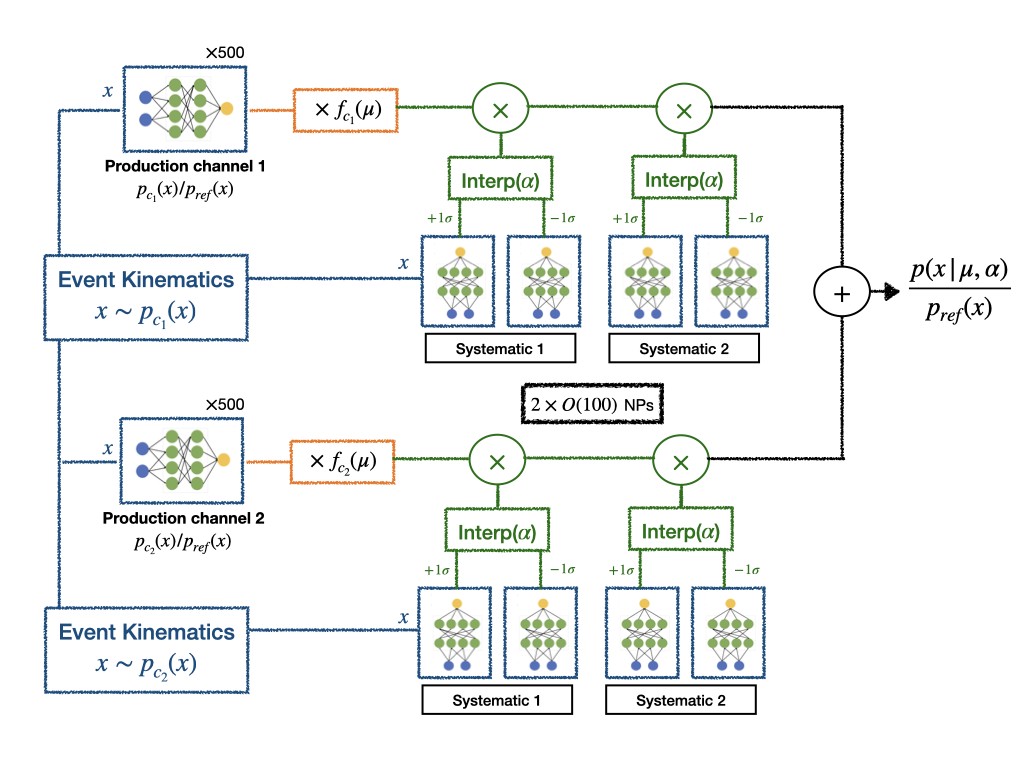

In [1]:
import os, sys, importlib
# sys.path.append('/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/')

import nsbi_common_utils
from nsbi_common_utils import plotting, training, datasets, configuration
from nsbi_common_utils.training import density_ratio_trainer

from utils import calculate_preselection_observable, preselection_using_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random
import numpy as np

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/home/jsandesara_umass_edu/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-11-05 12:25:36.253480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-05 12:25:36.273181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-05 12:25:36.279255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-05 12:25:36.293798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CP

In [2]:
importlib.reload(sys.modules['nsbi_common_utils.configuration'])
from nsbi_common_utils import configuration

# Load the config file to get metadata like training features 
config = nsbi_common_utils.configuration.ConfigManager(file_path_string = './config.yml')


In [3]:
# Input features for training - these features are the same ones used for nominal training
features, features_scaling = config.get_training_features()

In [4]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

branches_to_load = features + ['presel_score']

# Initialize the nsbi_common_utils.datasets helper class
Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load =  branches_to_load)

# Load the full dataset, including systematic variations defined in the config file
dataset_incl_dict = Datasets.load_datasets_from_config(load_systematics = True)


In [5]:
# Filter out events to get the NSBI signal region (defined as "SR" in the config file)
dataset_SR_dict = Datasets.filter_region_by_type(dataset_incl_dict, region = "SR")

Density ratio training
===

Now we train the NNs to predict two ratios,

$$\frac{p_c(x|\alpha_m^+)}{p_\text{c}(x|\alpha_m^\pm)} \, , \frac{p_c(x|\alpha_m^-)}{p_\text{c}(x|\alpha_m^\pm)}$$

for each nuisance parameter $\alpha_m$, for each process $p_c$ that is affected by the corresponding nuisance parameter.

Here is a major computational bottleneck of this workflow - for $N_{syst}$ systematics affecting each of the $N_{proc}$ processes, we would need a total of 

$$N_{syst} \times N_{proc} \times 2$$

well-trained NNs. In our example with $N_{syst}=2$ and $N_{proc}=3$, this corresponds to a total of 12 NNs. Typically in LHC experiments $N_{syst}\approx O(10^2)$! This type of approach thus requires a GPU infrastructure for efficient optimizations.

In [6]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import density_ratio_trainer

PATH_TO_SAVED_DATA = './saved_datasets/'

NN_training_syst_process  = {}
path_to_ratios            = {}
path_to_figures           = {}
path_to_models            = {}

# rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now
rnd_seed_traintestsplit = random.randint(0, 2**32 - 1)

# If you want a fresh training, delete all existing models so they wont be loaded
# DELETE_EXISTING_MODELS = True
DELETE_EXISTING_MODELS = False


for process in config.get_basis_samples():
    
    NN_training_syst_process[process]   = {}
    path_to_ratios[process]             = {}
    path_to_figures[process]            = {}
    path_to_models[process]             = {}
    
    
    for dict_syst in config.config["Systematics"]:
        
        syst = dict_syst["Name"]

        NN_training_syst_process[process][syst] = {}
        path_to_ratios[process][syst]           = {}
        path_to_figures[process][syst]          = {}
        path_to_models[process][syst]           = {}

        for direction in ["Up", "Dn"]:
            
            samples_to_train = config.get_samples_in_syst_for_training(syst, direction)
            
            if (process not in samples_to_train):
                print(f"Nothing to train for {process} in {syst+direction} uncertainty")
                del NN_training_syst_process[process][syst], path_to_ratios[process][syst], path_to_figures[process][syst], path_to_models[process][syst]
                continue

            syst_key_name = syst + '_' + direction
            
            dataset_syst_nom = Datasets.prepare_basis_training_dataset(dataset_SR_dict["Nominal"], [process], dataset_SR_dict[syst_key_name], [process])

            # Save paths
            top_path                                    = f'{PATH_TO_SAVED_DATA}output_training_systematics/'
            output_name                                 = f'{process}_{syst}_{direction}'
            output_dir                                  = f'{top_path}general_output_{output_name}'
            path_to_ratios[process][syst][direction]    = f'{top_path}output_ratios_{output_name}/'
            path_to_figures[process][syst][direction]   = f'{top_path}output_figures_{output_name}/'
            path_to_models[process][syst][direction]    = f'{top_path}output_model_params_{output_name}/'
            
            NN_training_syst_process[process][syst][direction] = density_ratio_trainer(dataset_syst_nom, 
                                                                                   dataset_syst_nom['weights_normed'].to_numpy(),
                                                                                   dataset_syst_nom['train_labels'].to_numpy(),
                                                                                   features, 
                                                                                   features_scaling,
                                                                                   [syst+'_'+direction, process], 
                                                                                  output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures[process][syst][direction],
                                                                                    path_to_ratios=path_to_ratios[process][syst][direction], 
                                                                                    path_to_models=path_to_models[process][syst][direction],
                                                                                    delete_existing_models = DELETE_EXISTING_MODELS)
                


In [7]:
# For systematic uncertainty variations, we can use a calibration layer to regularize the small fluctuations in density ratio output
doCalibration = True
num_bins_cal = 50

USE_SAVED_MODELS = True
RECALIBRATE = True
num_ensemble_members = 1

plot_scaled_features = False

verbose_output = 1

scalerType = 'MinMax'
hidden_layers = 4
num_neurons = 1000
num_epochs = 100
batch_size = 10_000
initial_lr = 0.1

for process, process_dict in NN_training_syst_process.items():

    for syst, syst_dict in process_dict.items():
        
        for direction in syst_dict.keys():

            NN_training_syst_process[process][syst][direction].train_ensemble (  hidden_layers        = hidden_layers, 
                                                                                 neurons              = num_neurons, 
                                                                                 number_of_epochs     = num_epochs, 
                                                                                 batch_size           = batch_size, 
                                                                                 learning_rate        = initial_lr, 
                                                                                 scalerType           = scalerType, 
                                                                                 calibration          = doCalibration, 
                                                                                 type_of_calibration  = "histogram",
                                                                                 num_bins_cal         = num_bins_cal, 
                                                                                 callback             = True, 
                                                                                 callback_patience    = 30, 
                                                                                 callback_factor      = 0.01,
                                                                                 verbose              = verbose_output,
                                                                                 plot_scaled_features = plot_scaled_features,
                                                                                 load_trained_models  = USE_SAVED_MODELS,
                                                                                 recalibrate_output   = RECALIBRATE,
                                                                                 num_ensemble_members = num_ensemble_members
                                                                            )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            

starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_htautau_JES_Up/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.000055297037089


The sum of PDFs using the whole ensemble is 1.000055297037089



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_htautau_JES_Dn/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999833706720072


The sum of PDFs using the whole ensemble is 0.9999833706720072



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_htautau_TES_Up/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0001390284589045


The sum of PDFs using the whole ensemble is 1.0001390284589045



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_htautau_TES_Dn/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999682983034655


The sum of PDFs using the whole ensemble is 0.9999682983034655



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_ttbar_JES_Up/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000461661381508


The sum of PDFs using the whole ensemble is 1.0000461661381508



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_ttbar_JES_Dn/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000982125224702


The sum of PDFs using the whole ensemble is 1.0000982125224702



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_ttbar_TES_Up/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999999032969645


The sum of PDFs using the whole ensemble is 0.9999999032969645



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_ttbar_TES_Dn/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999934487904222


The sum of PDFs using the whole ensemble is 0.9999934487904222



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_ztautau_JES_Up/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000929151876061


The sum of PDFs using the whole ensemble is 1.0000929151876061



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_ztautau_JES_Dn/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000546316684542


The sum of PDFs using the whole ensemble is 1.0000546316684542



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_ztautau_TES_Up/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999958957044763


The sum of PDFs using the whole ensemble is 0.9999958957044763



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_datasets/output_training_systematics/output_model_params_ztautau_TES_Dn/


/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jsandesara_umass_edu/NSBI-workflow-tutorial/.pixi/envs/nsbi-env-gpu/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to th

Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999841970648845


The sum of PDFs using the whole ensemble is 0.9999841970648845





Diagnostic Checks
===

While traditionally, a NN observable is judged on the basis of its accuracy - for NSBI we are interested in the quality of the density ratios more than the discrimination power. The latter comes from the perfect modelling of the multi-dimensional likelihood ratios.

To ensure correct modelling, we run two main checks on the training:

- **Calibration closure test**

  The NNs are trained using the binary cross-entropy loss, which under ideal conditions leads to the NN converging to the score function:

  $$\hat{s}_\text{pred} = \frac{p_\text{c}(x)}{p_\text{c}(x)+p_\text{c}(x|\alpha_m^\pm)}$$

  that can be converted into the probability ratio we desire (likelihood ratio trick):

  $$\frac{p_\text{c}(x|\alpha_m^\pm)}{p_\text{c}(x)} = \frac{\hat{s}_\text{pred}(x)}{1-\hat{s}_\text{pred}(x)}$$

  For the NNs to be well-calibrated, we use the Monte Carlo samples to verify the equality:


  $$\left[\frac{p_\text{c}(x|\alpha_m^\pm)}{p_\text{c}(x|\alpha_m^\pm)+p_\text{c}(x)}\right]_\text{NN} \sim \left[\frac{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}}{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}+\mathcal{N}_{c, \alpha_m^\pm}^{I(x|\hat{s}_\text{pred})}}\right]_\text{MC}$$

  where we bin the events from $p_c$ and $p_\text{ref}$ MC samples, denoted by $\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}$ and $\mathcal{N}_{c, \alpha_m^\pm}^{I(x|\hat{s}_\text{pred})}$ respectively where $I(x|\hat{s}_\text{pred})$ returns the index of the $\hat{s}_\text{pred}$ bin in which an event $x$ falls.
 


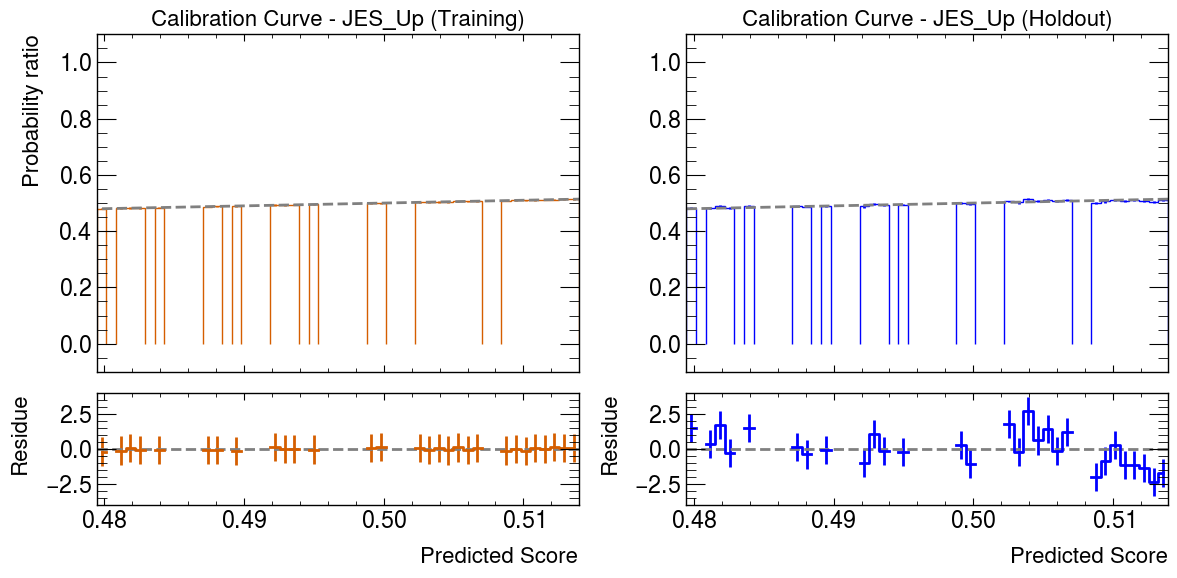

<Figure size 800x600 with 0 Axes>

In [8]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["Up"].make_calib_plots(nbins=num_bins_cal, observable='score')


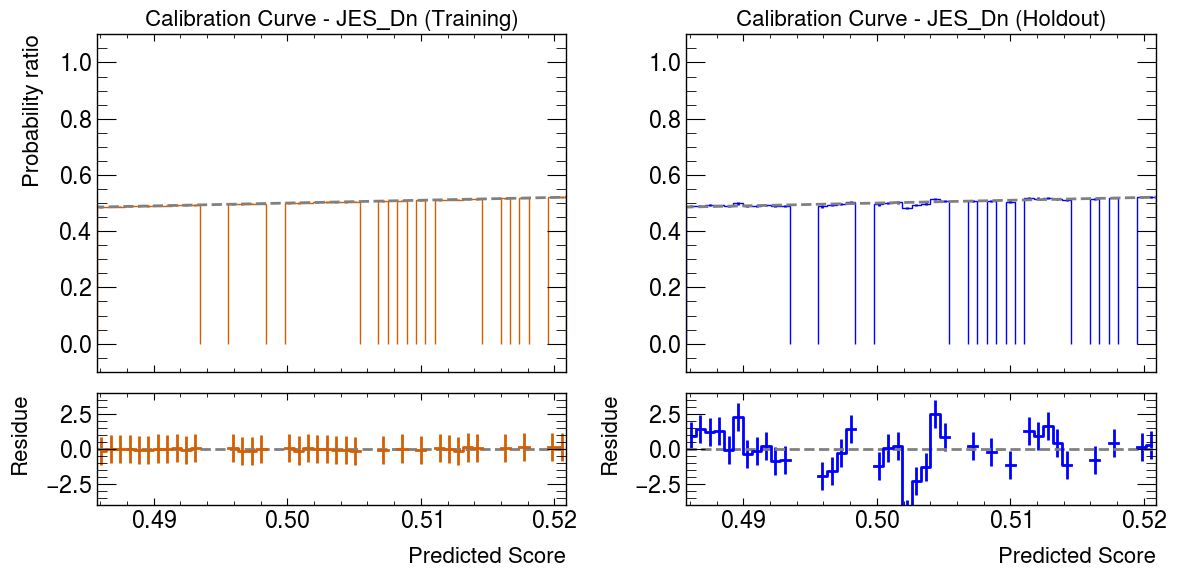

<Figure size 800x600 with 0 Axes>

In [9]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["Dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


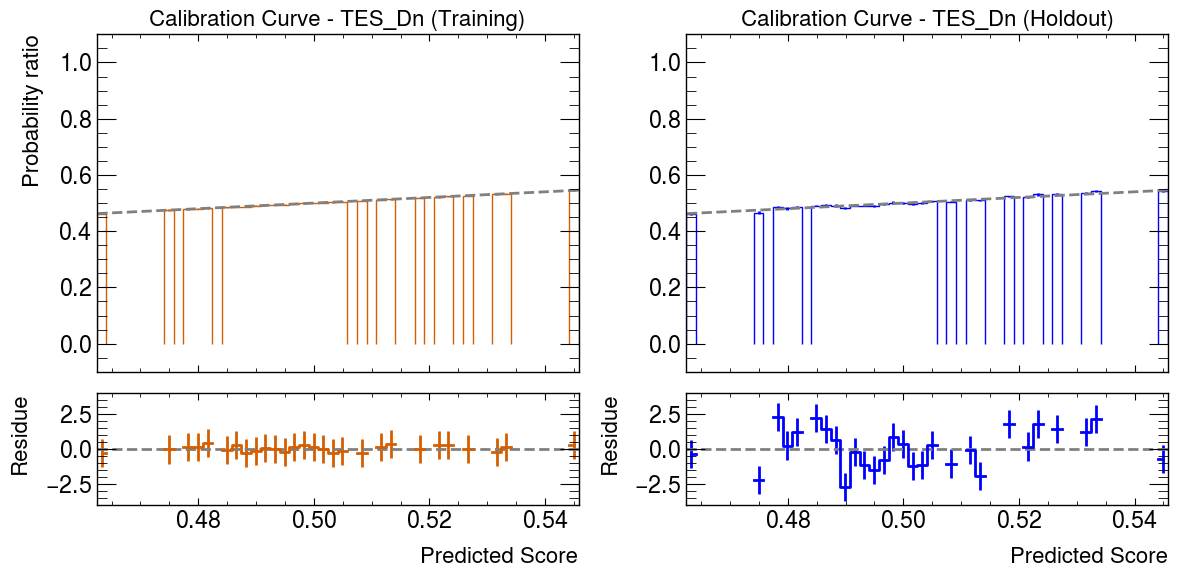

<Figure size 800x600 with 0 Axes>

In [10]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["Dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


## Density ratio reweighting closure tests
  
  Despite having a well-calibrated output and thus a robust probabilistic interpretation, the trained density ratios might not capture the full multi-dimensional event information $x$. In other words, the NNs might still be biased estimators of the optimal score function, as defined in the CARL paper (link).

  The next diagnostic involves verifying the following equality using 1D projections of $x$:

  $$\frac{p_\text{c}(x|\alpha_m^\pm)}{p_\text{c}(x)} \times p_\text{c}(x) \sim p_\text{c}(x|\alpha_m^\pm)$$

  We can do this one-by-one for all the observables used to model the density ratios, and also possibly the observables not used directly in the training but can still be well-estimated due to the NN learning the right physics.

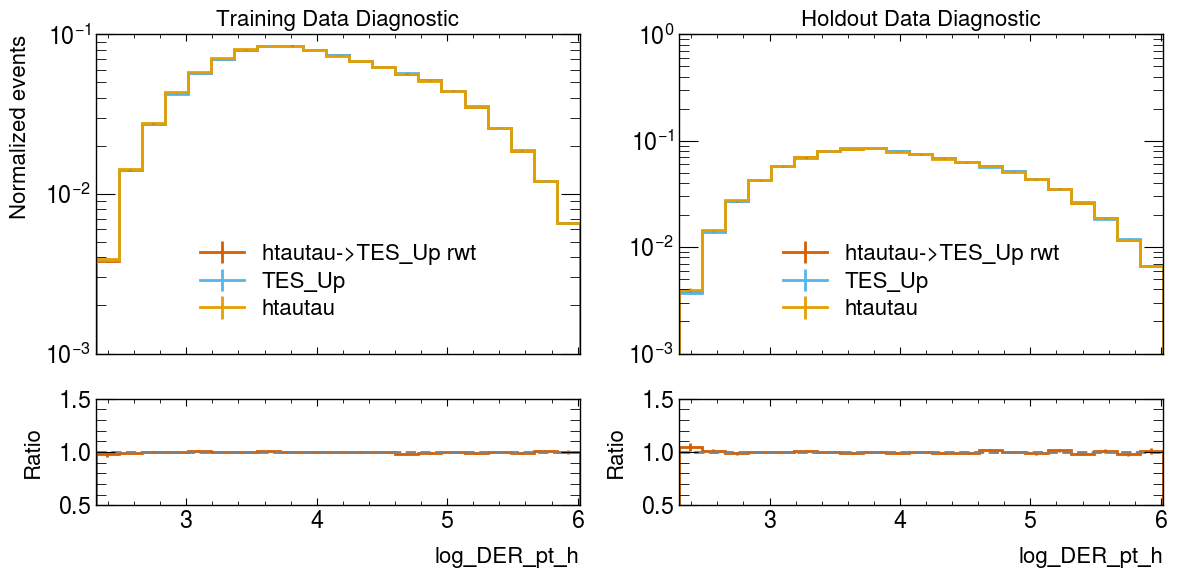

<Figure size 800x600 with 0 Axes>

In [11]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["Up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


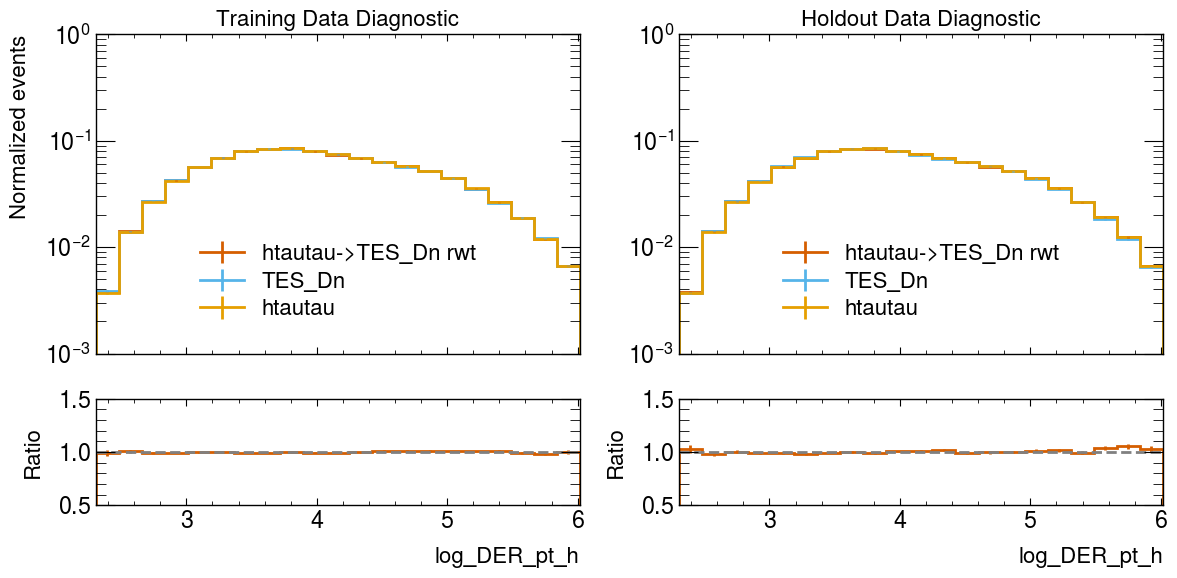

<Figure size 800x600 with 0 Axes>

In [12]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["Dn"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


Save the model output
--

Save the density ratios corresponding to each NP $\alpha_m = \alpha_m^\pm$ and process $p_\text{c}(x|\alpha_m^\pm)$ as a set of `numpy` arrays for use in the `Parameter_Fitting_with_Systematics.ipynb` notebook.

The trained models are also saved automatically by the training class for direct use in inference, or for evaluating on real data.

In [13]:
ensemble_aggregation_type = 'mean_ratio'

path_to_load = "saved_datasets/dataset_Asimov.root"
dataset_Asimov_SR = nsbi_common_utils.datasets.load_dataframe_from_root(path_to_load     = path_to_load,
                                                                      tree_name        = "nominal",
                                                                      branches_to_load = branches_to_load)

path_to_saved_ratios = {}

for process in config.get_basis_samples():

    path_to_saved_ratios[process] = {}
    
    for dict_syst in config.config["Systematics"]:

        syst = dict_syst["Name"]
        
        if (process not in dict_syst["Samples"]) | (dict_syst["Type"] != "NormPlusShape"): continue

        path_to_saved_ratios[process][syst] = {}
        
        for direction in ["Up", "Dn"]:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset and save as numpy arrays
            path_to_saved_ratios[process][syst][direction] = NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_Asimov_SR, 
                                                                                        aggregation_type = ensemble_aggregation_type)


Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

